# Wildfire Analysis: Australia & New Zealand

This notebook analyzes historical wildfire data to identify high-risk areas.
We use **Pandas** for data manipulation and **Matplotlib/Seaborn** for visualization.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os


sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Data Loading
We download the latest version of the dataset from Kaggle.

In [11]:

path = kagglehub.dataset_download("carlosparadis/fires-from-space-australia-and-new-zeland")
print("Path to dataset files:", path)

csv_file = None
for root, dirs, files in os.walk(path):
    for file in files:
        if "archive" in file and file.endswith(".csv"):
            csv_file = os.path.join(root, file)
            break

if csv_file:
    print(f"Loading {csv_file}...")
    df = pd.read_csv(csv_file)
    print(f"Loaded {len(df)} records.")
else:
    print("Could not find archive CSV. Loading first available CSV.")
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".csv"):
                df = pd.read_csv(os.path.join(root, file))
                break

Path to dataset files: /Users/amogh/.cache/kagglehub/datasets/carlosparadis/fires-from-space-australia-and-new-zeland/versions/1
Loading /Users/amogh/.cache/kagglehub/datasets/carlosparadis/fires-from-space-australia-and-new-zeland/versions/1/fire_archive_V1_96617.csv...
Loaded 184778 records.


## 2. Data Cleaning
We filter for high-confidence fire detections to ensure accuracy.

In [12]:

if 'confidence' in df.columns:
    if pd.api.types.is_numeric_dtype(df['confidence']):
        print("Filtering for numeric confidence > 50%...")
        df_clean = df[df['confidence'] > 50].copy()
    else:
        print("Filtering for categorical confidence ('h' or 'n')...")
        df_clean = df[df['confidence'].isin(['h', 'n'])].copy()
else:
    df_clean = df.copy()

Filtering for categorical confidence ('h' or 'n')...


## 3. Geospatial Analysis: Where are the fires?
We plot the Latitude and Longitude of all fire events. This recreates a map of Australia/NZ.

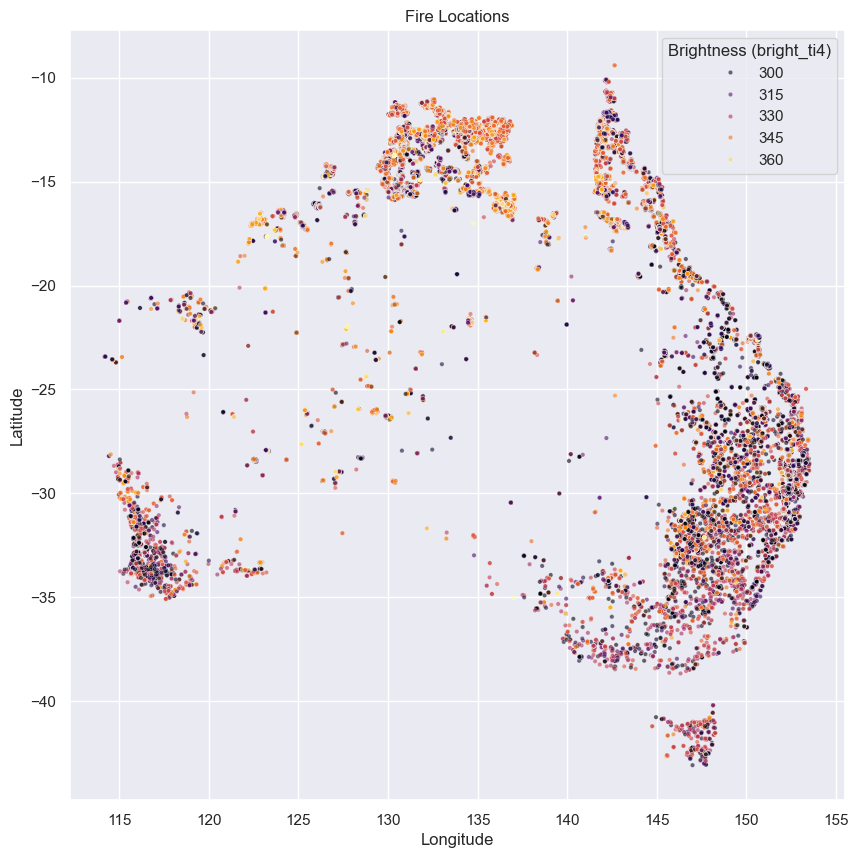

In [14]:

brightness_col = 'brightness'
if 'brightness' not in df_clean.columns:
    if 'bright_ti4' in df_clean.columns:
        brightness_col = 'bright_ti4'
    elif 'bright_ti5' in df_clean.columns:
        brightness_col = 'bright_ti5'
    else:
        brightness_col = None

plt.figure(figsize=(10, 10))
if brightness_col:
    sns.scatterplot(x='longitude', y='latitude', data=df_clean, hue=brightness_col, palette='inferno', s=10, alpha=0.6)
    plt.legend(title=f"Brightness ({brightness_col})")
else:
    sns.scatterplot(x='longitude', y='latitude', data=df_clean, s=10, alpha=0.6)

plt.title("Fire Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## 4. Fire Density Heatmap
This visualization highlights the areas **most likely to fall victim to fires** by showing the density of historical fire events.

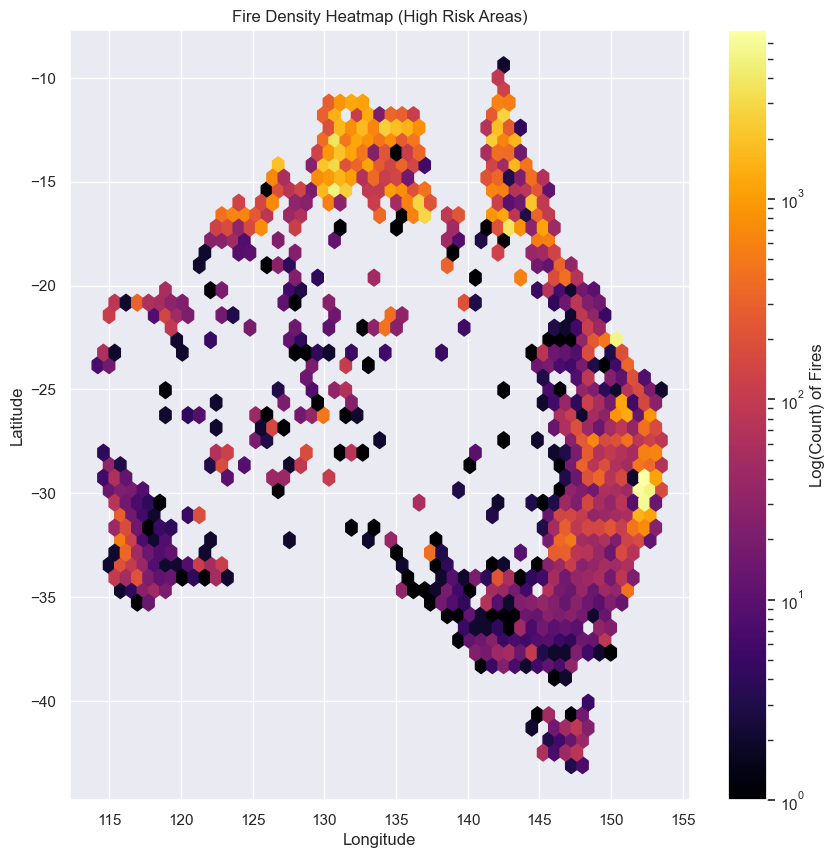

In [15]:
plt.figure(figsize=(10, 10))

plt.hexbin(df_clean['longitude'], df_clean['latitude'], gridsize=50, cmap='inferno', mincnt=1, bins='log')
plt.colorbar(label='Log(Count) of Fires')
plt.title("Fire Density Heatmap (High Risk Areas)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## 5. Temporal Analysis: When do fires occur?
We analyze the number of fires over time.

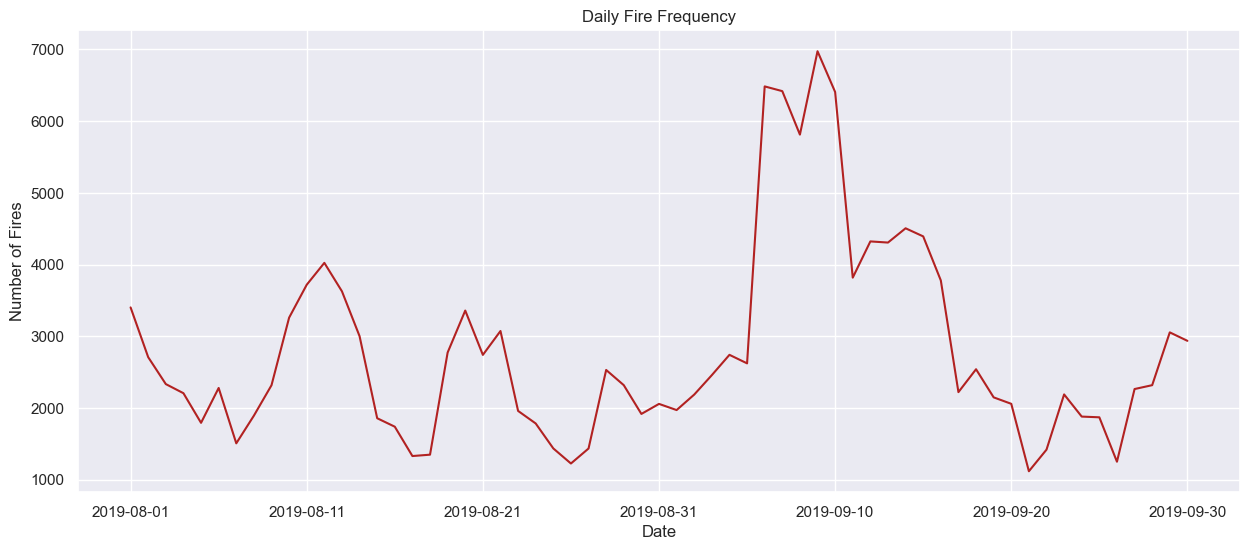

In [16]:
if 'acq_date' in df_clean.columns:
    fire_counts = df_clean.groupby('acq_date').size()
    
    plt.figure(figsize=(15, 6))
    fire_counts.plot(color='firebrick')
    plt.title("Daily Fire Frequency")
    plt.xlabel("Date")
    plt.ylabel("Number of Fires")
    plt.show()